# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [344]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import utils_prep
from api import Benchmark
import utils_prep2
import torch

In [345]:
bench_dir = "/home/sven/LCBench/data/11604705/fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [346]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [347]:
# Config
print("Config example:", test_data[0]["config"])
print("\n")
print("DATA Keys:", test_data[0].keys())

Config example: {'batch_size': 93, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.06145480624960298, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 402, 'mlp_shape': 'funnel', 'num_layers': True, 'learning_rate': 0.07306153347321286, 'momentum': 0.5844418984083981, 'weight_decay': 0.05967268273584057}


DATA Keys: dict_keys(['config', 'Train/loss', 'Train/train_accuracy', 'Train/val_accuracy', 'Train/train_cross_entropy', 'Train/val_cross_entropy', 'Train/train_balanced_accuracy', 'Train/val_balanced_accuracy', 'Train/test_result', 'Train/test_cross_entropy', 'Train/test_balanced_accuracy', 'Train/gradient_max', 'Train/gradient_mean', 'Train/gradient_median', 'Train/gradient_std', 'Train/gradient_q10', 'Train/gradient_q25', 'Train/gradient_q75', 'Train/gradient_q90',

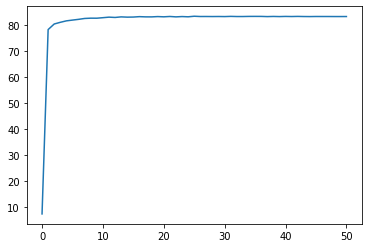

In [348]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

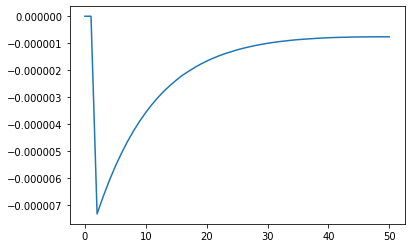

In [349]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

In [350]:
device = utils_prep2.check_cuda()


In [351]:
class LSTM_Net(torch.nn.Module):
    
    def __init__(self, input_size, num_classes, hidden_size, seq_length, 
                 num_layers, config_size, bidirectional = False, drop_prob=0.5, relative_size = 0.2):
        super(LSTM_Net, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_size
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.num_classes = num_classes
        self.config_size = config_size
        self.bidirectional = bidirectional
        
        if bidirectional == True:
            self.factor = 2
        else:
            self.factor = 1
        
        
        # self.forecaster = torch.nn.Embedding(100, embedding_dim)

        self.dropout = torch.nn.Dropout(drop_prob)
        #self.lstm = torch.nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_dim, 
        #                    num_layers = self.num_layers, dropout =drop_prob, bidirectional = bidirectional)
        
 
        self.rnn1 = torch.nn.RNN(input_size = self.input_size, hidden_size = self.hidden_dim, 
                            num_layers = self.num_layers, bidirectional = bidirectional)


        
        self.linear1 = torch.nn.Linear(self.config_size, int(self.hidden_dim*relative_size))
                                       
                                       
        self.linear2 = torch.nn.Linear(int(self.hidden_dim*relative_size),
                                       int(self.hidden_dim*relative_size))
                                       
                                       
        self.linear3 = torch.nn.Linear(self.hidden_dim + int(self.hidden_dim*relative_size),
                                       self.hidden_dim + int(self.hidden_dim*relative_size))

        
        self.linear4 = torch.nn.Linear(self.hidden_dim + int(self.hidden_dim*relative_size), self.hidden_dim//2)
        
        self.linear5 = torch.nn.Linear(self.hidden_dim//2, num_classes)
        
        
        self.dropout2 = torch.nn.Dropout(drop_prob)
        
        
        self.linear_reduce1 = torch.nn.Linear(self.hidden_dim*10*self.factor, self.hidden_dim*5*self.factor)

        self.linear_reduce2 = torch.nn.Linear(self.hidden_dim*5*self.factor, self.hidden_dim*self.factor)

        self.linear_reduce3 = torch.nn.Linear(self.hidden_dim*self.factor, self.hidden_dim)


    
    def forward(self, x, configs, hidden):
        
        
        batch_size = x.size(0)
        
        x = torch.t(x)

        x=x.unsqueeze(-1)
        
        x = x.float()
        
        #forecast = self.forecaster(x)

        lstm_x, hidden = self.rnn1(x, hidden)
        
        lstm_x = lstm_x.permute(1,0,2)

        lstm_x = lstm_x.contiguous().view(batch_size, -1)
        #print(lstm_x.size())

        # lstm_x = lstm_x.contiguous().view(-1, self.hidden_dim)
        
        x = self.dropout(lstm_x)
        # try 
        x = lstm_x
        
        x = torch.nn.functional.relu(self.linear_reduce1(x))
        x = torch.nn.functional.relu(self.linear_reduce2(x))
        x = torch.nn.functional.relu(self.linear_reduce3(x))


        x_config = torch.nn.functional.relu(self.linear1(configs))
        x_config = torch.nn.functional.relu(self.linear2(x_config))

        x_cat =  torch.cat([x, x_config], dim =1)

        
        x_cat = torch.nn.functional.relu(self.linear3(x_cat))
        
        #x_cat = self.dropout2(x_cat)
        
        x_cat = torch.nn.functional.relu(self.linear4(x_cat))
        x_cat = self.linear5(x_cat)

        
        x_cat = x_cat.view(batch_size, -1)
        x_cat = x_cat[:,-1]
        
        return x_cat, hidden
    
    def init_hidden(self, batch_size = 32):
        
        if self.bidirectional == False:
            return torch.randn(self.num_layers, batch_size, self.hidden_dim)
        else:
            return torch.randn(self.num_layers*2, batch_size, self.hidden_dim)

    

In [352]:
### alternative weighted MSE Loss


def weighted_mse_loss(prediction, target, weight):
    ### construct weight vector
        
    return torch.sum((prediction-target)**2)




In [353]:
#### calculate weights

weights = [1/(len([x for x in train_targets if x < 80.0])), 1/(len([x for x in train_targets if x >= 80.0]))]


In [354]:
def create_model(hidden_dim, num_layers, lr= 0.001, relative_size = 0.75, weight_decay = 0.001, bidirectional = False):
    
    
    def weights_init(m):
        for name, param in m.named_parameters():
            torch.nn.init.uniform_(param) 
    
    input_size = 1
    outcome_dim = 1
    embedding_dim = 400
    seq_length = 10
    config_size = 7

    model = LSTM_Net(input_size, outcome_dim, hidden_dim, seq_length, num_layers, config_size,
                     relative_size = relative_size, bidirectional = bidirectional)
    model.to(device)
    
    model.apply(weights_init)


    criterion = torch.nn.MSELoss()
    criterion_val = torch.nn.MSELoss(reduction = "sum")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
    
    return model, optimizer, criterion, criterion_val

In [355]:
def train_validate_model(model, optimizer, criterion, criterion_val):
    
    epochs = 3000
    counter = 0
    print_every = 100

    clip = 5
    valid_loss_min = np.Inf

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_data_loader))

    

    model.train()

    for i in range(epochs):


        for batches, configs , labels in train_data_loader:
            counter += 1

            batch_size_calc = len(labels)
            hidden = model.init_hidden(batch_size=batch_size_calc)


            model.zero_grad()

            output, hidden = model(batches, configs, hidden)


            loss = abs(criterion(output.squeeze(), labels.float()))
            loss.backward()


            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()


            if counter%print_every == 0:

                val_losses = []
                val_losses_sum = []
                model.eval()

                for inp,configs, lab in val_data_loader:

                    batch_size_calc = len(lab)

                    val_h = model.init_hidden(batch_size = batch_size_calc)


                    inp, lab = inp.to(device), lab.to(device)
                    out, val_h = model(inp, configs,val_h)
                    val_loss = criterion(out.squeeze(), lab.float())
                    val_losses.append(val_loss.item())
                    
                    val_loss_sum = criterion_val(out.squeeze(), lab.float())/(batch_size_calc)
                    val_losses_sum.append(val_loss_sum.item())

                    print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses_sum)))

                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), '/home/sven/LCBench/state_dict.pt')
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses_sum)))
                    valid_loss_min = np.mean(val_losses_sum)
                
                model.train()
                
            scheduler.step()


    return


In [356]:
def test_model(model, criterion, criterion_val):
    
    model.load_state_dict(torch.load('/home/sven/LCBench/state_dict.pt'))

    test_losses = []
    val_losses_sum = []
    msqrt = 0
    counter = 0


    model.eval()
    for inputs,configs, labels in test_data_loader:
        counter = counter +1
        batch_size_calc = len(labels)
        h = model.init_hidden(batch_size_calc)
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs,configs, h)
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        
                                    
        test_loss_sum = (criterion_val(output.squeeze(), labels.float()))/batch_size_calc
        val_losses_sum.append(test_loss_sum.item())
        
        pred = (output.squeeze())

        msqrt = msqrt + mean_squared_error(labels.detach().numpy(), pred.detach().numpy())
        
    
        print((labels.detach()))
        print((pred.detach()))
    print(counter)
    total_test_acc = msqrt
    print("TOTAL Loss: {:.3f}".format(total_test_acc))
    test_acc2 = msqrt/counter
    
    print("Msqrt: {:.3f}".format(test_acc2))

    print("Test loss: {:.3f}".format(np.mean(val_losses_sum)))
    
    return test_acc2, np.mean(val_losses_sum)


In [357]:
from utils import prep_data



train_data_loader = prep_data(train_data, train_targets, batch_size = 32,first_n_epochs = 10 )
test_data_loader = prep_data(test_data, test_targets, batch_size = 32,first_n_epochs = 10 )
val_data_loader = prep_data(val_data, val_targets, batch_size = 32, first_n_epochs=10)


model, optimizer, criterion, criterion_val = create_model(50, 3, bidirectional = True)
train_validate_model(model, optimizer, criterion, criterion_val)
    
    


Epoch: 4/3000... Step: 100... Loss: 1743243773613363429376.000000... Val Loss: 1742364586523607695360.000000
Epoch: 4/3000... Step: 100... Loss: 1743243773613363429376.000000... Val Loss: 1742364516154863517696.000000
Epoch: 4/3000... Step: 100... Loss: 1743243773613363429376.000000... Val Loss: 1742364586523607695360.000000
Epoch: 4/3000... Step: 100... Loss: 1743243773613363429376.000000... Val Loss: 1742364621707979784192.000000
Epoch: 4/3000... Step: 100... Loss: 1743243773613363429376.000000... Val Loss: 1742364811703589011456.000000
Epoch: 4/3000... Step: 100... Loss: 1743243773613363429376.000000... Val Loss: 1742364867998584406016.000000
Epoch: 4/3000... Step: 100... Loss: 1743243773613363429376.000000... Val Loss: 1742364847893228814336.000000
Epoch: 4/3000... Step: 100... Loss: 1743243773613363429376.000000... Val Loss: 1742364762445468139520.000000
Epoch: 4/3000... Step: 100... Loss: 1743243773613363429376.000000... Val Loss: 1742364789811090817024.000000
Epoch: 4/3000... St

Epoch: 19/3000... Step: 600... Loss: 12960498681118720.000000... Val Loss: 12327069388111872.000000
Epoch: 19/3000... Step: 600... Loss: 12960498681118720.000000... Val Loss: 12327067240628224.000000
Epoch: 19/3000... Step: 600... Loss: 12960498681118720.000000... Val Loss: 12327067956456106.000000
Epoch: 19/3000... Step: 600... Loss: 12960498681118720.000000... Val Loss: 12327068582805504.000000
Epoch: 19/3000... Step: 600... Loss: 12960498681118720.000000... Val Loss: 12327074327324262.000000
Epoch: 19/3000... Step: 600... Loss: 12960498681118720.000000... Val Loss: 12327076725347670.000000
Epoch: 19/3000... Step: 600... Loss: 12960498681118720.000000... Val Loss: 12327076444129572.000000
Epoch: 19/3000... Step: 600... Loss: 12960498681118720.000000... Val Loss: 12327073951514624.000000
Epoch: 19/3000... Step: 600... Loss: 12960498681118720.000000... Val Loss: 12327074637516344.000000
Epoch: 19/3000... Step: 600... Loss: 12960498681118720.000000... Val Loss: 12327074005201716.000000


Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157434768.000000
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157414968.000000
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157414138.666667
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157414920.000000
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157432272.000000
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157444709.333333
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157438676.571429
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157433068.000000
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157433180.444444
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157436326.400000
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Loss: 157436029.090909
Epoch: 38/3000... Step: 1200... Loss: 604606400.000000... Val Los

Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228122624.000000
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228054656.000000
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228049962.666667
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228057312.000000
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228075289.600000
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228097642.666667
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228082194.285714
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228080400.000000
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228068337.777778
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228076505.600000
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000... Val Loss: 1228084154.181818
Epoch: 57/3000... Step: 1800... Loss: 748244160.000000

Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5131989.000000
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5036625.250000
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5033959.166667
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5102680.625000
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5093506.100000
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5093372.083333
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5111122.285714
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5090779.312500
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5112549.611111
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5110231.000000
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5139731.454545
Epoch: 79/3000... Step: 2500... Loss: 7392659.500000... Val Loss: 5132945.208333
Epoch: 79/3000... Step: 2500

Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 42.889034
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 41.181177
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 48.855546
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 43.248723
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 46.029842
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 56.738133
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 53.641831
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 51.640543
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 49.007501
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 52.028452
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 53.692101
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 54.906202
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 54.048067
Epoch: 100/3000... Step: 3200... Loss: 25.167654... Val Loss: 54

Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 28.467133
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 23.588441
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 29.250021
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 27.411892
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 30.434677
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 41.288611
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 39.228500
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 36.929516
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 35.477462
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 36.602158
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 37.347266
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 37.757780
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 37.275732
Epoch: 122/3000... Step: 3900... Loss: 43.895729... Val Loss: 37

Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 10.090656
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 8.548311
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 10.050796
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 9.802365
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 10.787862
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 16.877904
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 16.092497
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 15.512576
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 15.414512
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 15.070917
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 14.399591
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 15.209592
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 15.419868
Epoch: 144/3000... Step: 4600... Loss: 10.835105... Val Loss: 16.4

Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 6.072730
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 4.774613
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 5.879378
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 5.579702
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 6.547786
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 7.768533
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 7.379387
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 7.213377
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 7.005755
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 6.748039
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 6.525376
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 7.155626
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 7.100515
Epoch: 166/3000... Step: 5300... Loss: 8.254356... Val Loss: 7.775154
Epoch: 166/3000... S

Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 5.246402
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 4.698535
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 5.292212
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 5.098905
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 6.114858
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 6.642263
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 6.265608
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 6.083495
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 5.906320
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 5.815569
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 5.689804
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 6.265236
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 6.161953
Epoch: 191/3000... Step: 6100... Loss: 4.952679... Val Loss: 6.828522
Epoch: 191/3000... S

Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 4.364709
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 4.505805
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 4.957756
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 4.281142
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 5.384651
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 5.977288
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 5.627822
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 5.392524
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 5.133700
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 5.136246
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 5.034818
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 5.594924
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 5.426648
Epoch: 216/3000... Step: 6900... Loss: 3.473738... Val Loss: 6.135006
Epoch: 216/3000... S

Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 4.032876
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 4.381591
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 4.931999
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 4.341275
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 5.230054
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 5.662537
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 5.211997
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 5.020111
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 4.788953
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 4.601600
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 4.416536
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 5.043526
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 4.913091
Epoch: 241/3000... Step: 7700... Loss: 2.766658... Val Loss: 5.687981
Epoch: 241/3000... S

Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 9.134720
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 9.279838
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 10.537592
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 10.234869
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 11.028493
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 11.151380
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 10.678354
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 10.545715
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 10.297077
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 9.882720
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 9.583048
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 10.194306
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 10.099363
Epoch: 266/3000... Step: 8500... Loss: 4.278063... Val Loss: 10.639174
Epoch: 266

Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 4.407927
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 4.539577
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 4.790385
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 4.274293
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 5.254899
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 5.670111
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 5.263965
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 5.136493
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 4.934562
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 4.764356
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 4.638604
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 5.196489
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 5.028337
Epoch: 291/3000... Step: 9300... Loss: 3.439679... Val Loss: 5.728666
Epoch: 291/3000... S

Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 3.606755
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 4.128850
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 4.899631
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 4.331209
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 5.448874
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 5.788395
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 5.247081
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 4.946509
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 4.720513
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 4.473075
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 4.301770
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 4.977086
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 4.821433
Epoch: 316/3000... Step: 10100... Loss: 2.664490... Val Loss: 5.600000
Epoch:

Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 4.268791
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 4.425137
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 5.568712
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 4.895900
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 5.333657
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 5.559380
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 5.118123
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 4.996151
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 4.759466
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 4.471786
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 4.278265
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 4.864974
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 4.736526
Epoch: 341/3000... Step: 10900... Loss: 3.045393... Val Loss: 5.427513
Epoch:

Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 4.466980
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 4.753734
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 5.101998
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 4.736047
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 5.015342
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 5.645900
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 5.228594
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 5.122985
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 4.870672
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 4.645327
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 4.480649
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 5.251991
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 5.132897
Epoch: 366/3000... Step: 11700... Loss: 2.341727... Val Loss: 5.772028
Epoch:

Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 3.577260
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 3.966257
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 5.603447
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 4.834263
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 5.313467
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 5.593288
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 5.129284
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 4.841415
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 4.608580
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 4.345583
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 4.259982
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 4.994963
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 4.870810
Epoch: 391/3000... Step: 12500... Loss: 3.062421... Val Loss: 5.594117
Epoch:

Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 5.210062
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 5.021597
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.642198
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.289729
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.324305
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.973412
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.633858
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.505515
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.384649
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.210449
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.138266
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.899846
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 4.786257
Epoch: 416/3000... Step: 13300... Loss: 3.877839... Val Loss: 5.602810
Epoch:

Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.324614
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.503133
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 5.581440
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.750571
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.493259
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 5.130446
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.709666
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.486263
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.278019
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.120813
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.060132
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.997936
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 4.851489
Epoch: 441/3000... Step: 14100... Loss: 3.677078... Val Loss: 5.609260
Epoch:

Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 4.099876
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 4.419928
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 3.779457
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 3.477291
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 3.327449
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 4.070173
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 3.843479
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 3.856359
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 3.762102
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 3.575625
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 3.502532
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 4.237504
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 4.125097
Epoch: 466/3000... Step: 14900... Loss: 2.042654... Val Loss: 4.837669
Epoch:

Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 4.658627
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 4.514957
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 3.754114
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 3.470082
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 3.161910
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 3.751253
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 3.522049
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 3.603641
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 3.532023
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 3.443312
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 3.550873
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 4.273484
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 4.183474
Epoch: 491/3000... Step: 15700... Loss: 2.675710... Val Loss: 4.901217
Epoch:

Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 4.815593
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 4.612976
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 4.097438
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 3.760360
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 3.498127
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 4.094643
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 3.985224
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 4.049345
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 3.948908
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 3.767875
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 3.753775
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 4.660169
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 4.567108
Epoch: 516/3000... Step: 16500... Loss: 2.267400... Val Loss: 5.245752
Epoch:

Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 4.294926
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 4.448474
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 3.678372
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 3.481365
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 3.312137
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 3.802383
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 3.553515
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 3.525286
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 3.450750
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 3.302813
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 3.415982
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 4.228451
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 4.198801
Epoch: 541/3000... Step: 17300... Loss: 2.113219... Val Loss: 4.902189
Epoch:

Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 5.275381
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 5.597586
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 4.577527
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 4.194393
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 4.059781
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 4.641185
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 4.540305
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 4.573892
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 4.533047
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 4.418798
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 4.493108
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 5.277509
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 5.176671
Epoch: 566/3000... Step: 18100... Loss: 2.899297... Val Loss: 5.968353
Epoch:

Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.926036
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 4.191904
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.643014
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.395488
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.203211
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.545660
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.408254
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.471853
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.399294
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.320940
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.377593
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 4.038332
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 3.976842
Epoch: 591/3000... Step: 18900... Loss: 2.210980... Val Loss: 4.706130
Epoch:

Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 4.498975
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 4.286113
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.331280
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.069448
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.180280
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.873374
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.655493
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.656427
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.608137
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.454901
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.340749
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.881974
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 3.859249
Epoch: 616/3000... Step: 19700... Loss: 1.867877... Val Loss: 4.673523
Epoch:

Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 4.626427
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 4.236348
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 3.299576
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 3.199243
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 3.073950
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 3.606215
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 3.477373
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 3.657220
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 3.587192
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 3.393099
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 3.462639
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 4.007966
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 3.919594
Epoch: 641/3000... Step: 20500... Loss: 1.182434... Val Loss: 4.579232
Epoch:

Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 5.136195
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 4.488346
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 3.911971
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 3.702148
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 3.492985
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 4.295704
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 4.069698
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 4.129624
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 4.018849
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 3.858951
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 3.771305
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 4.114155
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 4.059292
Epoch: 666/3000... Step: 21300... Loss: 1.643233... Val Loss: 4.718146
Epoch:

Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 7.343120
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 7.940142
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 7.145965
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 6.839013
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 6.748159
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 7.306397
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 7.135495
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 7.002312
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 6.991691
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 6.859587
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 7.356901
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 7.698912
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 7.578790
Epoch: 691/3000... Step: 22100... Loss: 4.140352... Val Loss: 8.369250
Epoch:

Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.251698
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.192518
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 3.561999
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 3.307132
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 3.937794
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.827324
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.580740
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.644536
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.485551
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.229932
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.060652
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.469028
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.355073
Epoch: 716/3000... Step: 22900... Loss: 1.052248... Val Loss: 4.991921
Epoch:

Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 4.145133
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 3.409476
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 2.973602
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 2.835518
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 2.724011
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 3.128350
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 3.001866
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 3.167807
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 3.114699
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 3.145288
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 3.451045
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 3.831999
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 3.775325
Epoch: 741/3000... Step: 23700... Loss: 0.897577... Val Loss: 4.408182
Epoch:

Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 3.730249
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 3.240796
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 2.545358
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 2.441784
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 2.914444
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 3.157913
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 2.972727
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 2.987531
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 2.916150
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 2.922485
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 3.252682
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 3.616591
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 3.539480
Epoch: 766/3000... Step: 24500... Loss: 0.912382... Val Loss: 4.199951
Epoch:

Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 4.004699
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.738046
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.094370
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.135555
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 2.930807
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.352935
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.173898
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.351259
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.221924
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.109911
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 2.985695
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.112008
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.054384
Epoch: 791/3000... Step: 25300... Loss: 0.945712... Val Loss: 3.783210
Epoch:

Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 5.710237
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.670889
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.214476
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.313137
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.350143
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.642514
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.530198
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.838873
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.810096
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.697273
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.595512
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.886378
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 4.871297
Epoch: 816/3000... Step: 26100... Loss: 1.368152... Val Loss: 5.478656
Epoch:

Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.834526
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.265783
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 2.649586
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 2.845370
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 2.747836
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.168408
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.062522
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.183609
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.121993
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.054035
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.018131
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.285016
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.188172
Epoch: 841/3000... Step: 26900... Loss: 0.972732... Val Loss: 3.890548
Epoch:

Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 3.632935
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 3.201901
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 2.770540
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 2.820922
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 2.865365
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 3.121687
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 2.977344
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 3.059885
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 2.979227
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 2.880925
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 2.959514
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 3.189961
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 3.119468
Epoch: 866/3000... Step: 27700... Loss: 0.700839... Val Loss: 3.892436
Epoch:

Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 3.775769
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 3.126345
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 2.684990
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 2.828153
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 2.677278
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 3.025918
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 2.836511
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 2.957256
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 2.929970
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 2.959563
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 3.154452
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 3.372954
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 3.295068
Epoch: 891/3000... Step: 28500... Loss: 0.762576... Val Loss: 4.020891
Epoch:

Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 3.860122
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 3.200154
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 2.671402
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 2.639239
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 2.772100
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 3.126320
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 2.966044
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 3.210163
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 3.139776
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 3.056229
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 2.970253
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 3.079855
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 2.996745
Epoch: 916/3000... Step: 29300... Loss: 0.801148... Val Loss: 3.709460
Epoch:

Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.586973
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.514019
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.330453
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.067541
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.252151
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.878094
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.533562
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.340083
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.246453
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.366965
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.212655
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.442226
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 3.347204
Epoch: 941/3000... Step: 30100... Loss: 3.568812... Val Loss: 4.149710
Epoch:

Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 3.867687
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 3.076770
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 2.542412
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 2.555175
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 2.544799
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 2.943721
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 2.782298
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 3.035001
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 2.977607
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 2.962498
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 3.002467
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 3.078389
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 3.027160
Epoch: 966/3000... Step: 30900... Loss: 0.805358... Val Loss: 3.702199
Epoch:

Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 4.753398
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 4.954159
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 4.429144
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 4.152540
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 4.073381
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 6.712530
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 6.294304
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 6.047244
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 5.823542
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 5.790548
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 5.631110
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 5.628273
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 5.410955
Epoch: 991/3000... Step: 31700... Loss: 3.567371... Val Loss: 6.116163
Epoch:

Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 4.377299
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 4.240279
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.572462
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.288881
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.025936
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.592355
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.449320
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.507147
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.451017
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.572554
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.560598
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.617498
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 3.519478
Epoch: 1016/3000... Step: 32500... Loss: 2.085652... Val Loss: 4

Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 3.665126
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 3.048170
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.526587
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.440699
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.274943
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.591013
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.569358
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.801797
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.763309
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.770808
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.922637
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.950579
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 2.897435
Epoch: 1041/3000... Step: 33300... Loss: 1.281562... Val Loss: 3

Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 4.497614
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 3.515650
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 2.881857
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 2.903902
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 2.653584
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 3.013409
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 2.990678
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 3.223450
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 3.181554
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 3.173174
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 3.000719
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 3.055438
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 3.015958
Epoch: 1066/3000... Step: 34100... Loss: 0.594314... Val Loss: 3

Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 4.177776
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 3.300454
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 2.581618
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 2.403851
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 2.427254
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 2.902589
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 2.768030
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 3.041087
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 2.959473
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 3.030151
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 3.242661
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 3.184796
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 3.102494
Epoch: 1088/3000... Step: 34800... Loss: 1.411936... Val Loss: 3

Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 5.796347
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 4.144883
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 3.402808
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 3.374846
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 3.326906
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 3.956766
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 3.901174
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 4.405047
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 4.276473
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 4.193925
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 4.363804
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 4.278821
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 4.199518
Epoch: 1113/3000... Step: 35600... Loss: 1.875479... Val Loss: 4

Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 3.581762
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 3.388472
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 2.891066
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 2.745296
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 2.526714
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 3.063280
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 2.989257
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 3.170428
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 3.136333
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 3.158342
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 3.193066
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 3.139991
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 3.064676
Epoch: 1138/3000... Step: 36400... Loss: 1.514071... Val Loss: 3

Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 4.545219
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 3.360423
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 2.630046
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 2.425435
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 2.491265
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 3.047857
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 2.931736
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 3.209608
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 3.169359
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 3.144356
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 3.115617
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 3.024235
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 2.944843
Epoch: 1163/3000... Step: 37200... Loss: 1.737293... Val Loss: 3

Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 3.555100
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 3.158701
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.573678
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.448334
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.211658
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.648800
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.541471
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.811577
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.768866
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.782448
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.728925
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.667515
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 2.595525
Epoch: 1188/3000... Step: 38000... Loss: 1.211417... Val Loss: 3

Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.640490
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 4.197248
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.587591
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.376877
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.184444
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.816911
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.675512
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.748657
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.689548
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.788034
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.643468
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.558827
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 3.488140
Epoch: 1213/3000... Step: 38800... Loss: 3.044353... Val Loss: 4

Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 3.190058
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 3.151492
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.596783
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.310615
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.162121
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.679160
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.592187
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.777587
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.745132
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.842385
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.874186
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.807346
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 2.737194
Epoch: 1238/3000... Step: 39600... Loss: 0.828545... Val Loss: 3

Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.751992
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.705428
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.073425
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 3.729366
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 3.663118
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.542992
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.360977
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.340923
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.270123
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.347242
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.297376
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.192841
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4.106667
Epoch: 1263/3000... Step: 40400... Loss: 3.178111... Val Loss: 4

Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 4.028260
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 3.040408
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 2.523344
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 2.256845
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 2.127659
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 2.745334
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 2.680758
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 3.119662
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 3.022755
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 2.941059
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 2.840869
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 2.866703
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 2.783925
Epoch: 1288/3000... Step: 41200... Loss: 1.459634... Val Loss: 3

Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4.984530
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4.374197
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 3.869203
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 3.632292
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 3.565410
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4.407701
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4.305052
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4.525740
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4.457305
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4.362333
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4.252863
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4.195368
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4.074447
Epoch: 1313/3000... Step: 42000... Loss: 3.011080... Val Loss: 4

Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 4.020977
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.809142
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.303063
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.053070
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 2.878714
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.551935
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.373162
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.476621
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.401723
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.459878
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.700945
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.550117
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 3.442879
Epoch: 1338/3000... Step: 42800... Loss: 1.148814... Val Loss: 4

Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 4.030256
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 3.003797
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 2.647426
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 2.466852
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 2.257193
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 2.822121
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 2.730299
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 3.048901
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 2.952557
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 2.853333
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 2.898794
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 2.873742
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 2.834501
Epoch: 1363/3000... Step: 43600... Loss: 0.808094... Val Loss: 3

Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 4.169976
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 3.409495
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 2.710673
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 2.376035
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 2.185842
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 3.383786
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 3.223141
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 3.428903
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 3.309623
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 3.366508
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 3.184593
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 3.233466
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 3.111096
Epoch: 1388/3000... Step: 44400... Loss: 0.770133... Val Loss: 3

Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 3.899395
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 2.782428
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 2.338360
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 2.085656
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 2.196722
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 2.785799
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 2.736740
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 3.276459
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 3.144807
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 3.077641
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 3.057035
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 3.067275
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 3.004572
Epoch: 1410/3000... Step: 45100... Loss: 0.313443... Val Loss: 3

Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 3.919299
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 2.806098
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 2.307003
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 2.228545
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 2.171127
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 2.775018
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 2.695746
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 3.129657
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 3.038260
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 2.954897
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 2.930900
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 2.967091
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 2.894111
Epoch: 1435/3000... Step: 45900... Loss: 0.566647... Val Loss: 3

Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 4.319597
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 3.400677
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 3.013053
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 2.952532
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 2.744887
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 6.822319
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 6.274051
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 6.385491
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 5.939052
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 5.603765
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 5.344829
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 5.163174
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 4.979091
Epoch: 1457/3000... Step: 46600... Loss: 1.345659... Val Loss: 5

Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 2.442262
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 2.257806
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 1.867732
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 1.662470
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 1.566115
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 2.954719
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 2.752376
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 2.872986
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 2.723134
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 2.737013
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 2.684612
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 2.587305
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 2.498964
Epoch: 1482/3000... Step: 47400... Loss: 0.523608... Val Loss: 3

Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.408835
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.432219
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.537128
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.163299
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.232338
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.749765
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.542789
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.626194
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.540223
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.758626
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.601248
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.441839
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 3.361139
Epoch: 1507/3000... Step: 48200... Loss: 2.812131... Val Loss: 4

Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 3.155638
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2.387274
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2.047975
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 1.903560
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 1.739033
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2.224276
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2.119122
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2.441920
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2.365757
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2.351808
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2.292151
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2.234112
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2.165333
Epoch: 1532/3000... Step: 49000... Loss: 0.532959... Val Loss: 2

Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 3.797604
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 3.332546
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 3.009464
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 2.771741
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 2.822983
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 3.807608
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 3.728003
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 4.193136
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 4.064519
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 4.009857
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 3.813672
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 3.714318
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 3.623920
Epoch: 1557/3000... Step: 49800... Loss: 1.006150... Val Loss: 4

Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 3.365208
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.858252
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.438632
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.204564
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.121650
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.673078
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.616786
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.802374
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.748950
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.895641
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.783921
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.769641
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 2.695936
Epoch: 1582/3000... Step: 50600... Loss: 0.662876... Val Loss: 3

Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 4.234678
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 2.965331
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 2.311703
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 2.045207
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 3.095305
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 4.072762
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 3.966476
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 4.568390
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 4.380650
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 4.132510
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 3.986998
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 3.961846
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 3.897866
Epoch: 1607/3000... Step: 51400... Loss: 1.021512... Val Loss: 4

Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 2.808102
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 2.149993
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 1.919002
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 1.700072
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 1.649562
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 2.251118
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 2.148415
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 2.364879
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 2.281103
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 2.259695
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 2.135196
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 2.067572
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 1.983266
Epoch: 1632/3000... Step: 52200... Loss: 0.456367... Val Loss: 2

Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 3.364325
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 2.493613
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 2.138478
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 2.008959
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 1.828568
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 2.413749
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 2.429412
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 3.080142
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 2.964623
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 2.895096
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 2.875026
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 2.769162
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 2.682218
Epoch: 1657/3000... Step: 53000... Loss: 0.694111... Val Loss: 3

Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 2.360065
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 2.168974
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 1.731041
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 1.573704
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 1.538528
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 2.123310
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 1.985291
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 2.130377
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 2.057449
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 2.135224
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 2.020263
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 2.017520
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 1.963685
Epoch: 1682/3000... Step: 53800... Loss: 0.515051... Val Loss: 2

Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 3.368445
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 2.365194
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 1.849269
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 1.604499
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 1.547745
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 2.688057
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 2.666907
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 3.617076
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 3.401618
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 3.300722
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 3.178232
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 3.089993
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 2.983483
Epoch: 1707/3000... Step: 54600... Loss: 1.301624... Val Loss: 3

Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 2.481144
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 1.984606
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 1.805268
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 1.543595
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 1.568924
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 2.260989
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 2.154747
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 2.476416
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 2.377320
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 2.417149
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 2.396738
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 2.351768
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 2.273438
Epoch: 1732/3000... Step: 55400... Loss: 0.466104... Val Loss: 2

Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 3.547237
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2.682830
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2.017531
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 1.725518
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 1.660437
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2.370151
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2.263493
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2.705471
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2.589783
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2.662450
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2.555167
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2.550067
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2.480889
Epoch: 1757/3000... Step: 56200... Loss: 1.242678... Val Loss: 2

Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2.965253
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2.209333
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 1.728539
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 1.631092
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 1.531412
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2.165552
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2.168113
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2.418999
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2.363938
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2.415542
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2.333829
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2.341349
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2.263966
Epoch: 1782/3000... Step: 57000... Loss: 0.393934... Val Loss: 2

Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 3.116274
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 2.469431
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 1.966204
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 1.758283
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 1.848243
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 3.190112
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 3.061166
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 3.448019
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 3.294793
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 3.215368
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 3.045309
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 2.921491
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 2.810578
Epoch: 1807/3000... Step: 57800... Loss: 0.796821... Val Loss: 3

Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2.555536
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2.364134
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 1.952122
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 1.915376
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 1.780387
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2.440621
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2.310562
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2.490060
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2.427722
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2.494281
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2.418430
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2.367351
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2.311133
Epoch: 1832/3000... Step: 58600... Loss: 0.555275... Val Loss: 2

Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 3.303116
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 2.568180
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 1.932927
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 1.668045
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 1.870019
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 2.938385
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 2.729418
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 2.975206
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 2.838496
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 2.880191
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 2.733994
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 2.626212
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 2.550432
Epoch: 1857/3000... Step: 59400... Loss: 1.239732... Val Loss: 3

Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 2.380132
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 1.823680
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 1.494944
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 1.464990
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 1.416173
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 1.945516
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 1.923873
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 2.375791
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 2.282478
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 2.369987
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 2.310595
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 2.211135
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 2.134126
Epoch: 1882/3000... Step: 60200... Loss: 0.418288... Val Loss: 2

Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 4.064701
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 2.748612
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 2.171011
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 1.943164
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 1.928389
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 2.481272
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 2.574944
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 3.046185
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 2.974972
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 2.959676
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 2.777428
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 2.733855
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 2.639599
Epoch: 1907/3000... Step: 61000... Loss: 0.565346... Val Loss: 3

Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 2.641547
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 1.975571
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 1.605078
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 1.513310
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 1.451295
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 2.173801
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 2.154635
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 2.499067
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 2.399607
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 2.338730
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 2.286910
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 2.221969
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 2.142696
Epoch: 1932/3000... Step: 61800... Loss: 0.381709... Val Loss: 2

Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 3.356712
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 2.213013
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 1.787429
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 1.642236
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 1.713489
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 2.394696
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 2.371546
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 3.208696
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 3.035663
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 2.971475
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 2.801882
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 2.736501
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 2.631096
Epoch: 1957/3000... Step: 62600... Loss: 1.193338... Val Loss: 2

Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 3.183383
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 2.341707
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 1.897251
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 1.644760
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 1.605906
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 2.186155
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 2.059209
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 2.331100
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 2.267292
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 2.325043
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 2.180179
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 2.098238
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 2.042846
Epoch: 1982/3000... Step: 63400... Loss: 0.454069... Val Loss: 2

Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 3.575286
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 2.327954
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 1.779253
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 1.574746
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 1.611884
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 2.223718
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 2.339369
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 3.188012
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 3.055505
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 2.972225
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 2.845316
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 2.833940
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 2.746649
Epoch: 2007/3000... Step: 64200... Loss: 1.323073... Val Loss: 3

Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2.818808
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2.044572
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 1.572235
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 1.452834
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 1.608070
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2.221781
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2.094259
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2.417959
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2.293455
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2.290434
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2.192003
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2.148095
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2.079554
Epoch: 2032/3000... Step: 65000... Loss: 0.253983... Val Loss: 2

Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 2.808490
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 1.995794
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 1.541784
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 1.335659
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 1.346201
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 1.913709
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 1.775010
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 2.052234
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 1.974057
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 2.045526
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 1.919690
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 1.893580
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 1.830340
Epoch: 2057/3000... Step: 65800... Loss: 1.662492... Val Loss: 2

Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 2.829182
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 1.902470
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 1.461071
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 1.290345
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 1.305775
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 1.911254
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 1.905055
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 2.245444
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 2.145361
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 2.126109
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 2.013783
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 2.043054
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 1.972276
Epoch: 2082/3000... Step: 66600... Loss: 0.476785... Val Loss: 2

Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 3.659836
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 2.365502
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 1.816739
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 1.570901
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 1.602495
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 2.161114
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 2.262645
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 3.442602
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 3.248668
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 3.214181
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 3.183507
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 3.138411
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 3.069901
Epoch: 2107/3000... Step: 67400... Loss: 1.291013... Val Loss: 3

Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 2.891905
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.986995
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.562994
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.397591
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.250529
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.806402
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.707153
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 2.066041
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.942624
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.968348
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.872173
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.925764
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 1.867673
Epoch: 2132/3000... Step: 68200... Loss: 0.468351... Val Loss: 2

Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 3.363146
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 2.305505
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 1.723265
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 1.551159
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 1.789947
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 2.440154
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 2.283971
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 2.777886
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 2.639299
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 2.670286
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 2.586145
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 2.554187
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 2.449018
Epoch: 2157/3000... Step: 69000... Loss: 0.864027... Val Loss: 2

Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 3.114241
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 2.113787
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 1.582029
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 1.405791
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 1.435736
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 1.985252
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 1.940710
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 2.433515
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 2.312711
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 2.286154
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 2.195352
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 2.228217
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 2.159936
Epoch: 2182/3000... Step: 69800... Loss: 0.343651... Val Loss: 2

Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 3.386652
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 2.380386
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 2.010379
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 1.800449
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 3.372818
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 3.916416
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 3.697520
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 4.023243
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 3.736280
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 3.636002
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 3.467261
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 3.497646
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 3.377494
Epoch: 2207/3000... Step: 70600... Loss: 0.426722... Val Loss: 3

Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 2.948911
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 2.115384
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 1.580993
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 1.389031
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 1.548299
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 2.072886
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 1.965659
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 2.292538
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 2.187214
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 2.162384
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 2.045187
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 2.038980
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 1.963908
Epoch: 2232/3000... Step: 71400... Loss: 0.289894... Val Loss: 2

Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 3.525839
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 2.438718
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 1.876757
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 1.636485
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 1.639313
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 2.186462
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 2.175867
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 2.749006
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 2.633473
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 2.659888
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 2.504494
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 2.530280
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 2.461579
Epoch: 2257/3000... Step: 72200... Loss: 0.439875... Val Loss: 2

Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 2.824742
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 1.936725
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 1.459524
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 1.360949
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 1.340850
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 1.906954
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 1.859602
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 2.218637
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 2.095191
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 2.072338
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 2.075882
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 2.021087
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 1.945674
Epoch: 2282/3000... Step: 73000... Loss: 0.340038... Val Loss: 2

Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2.677424
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2.126462
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 1.713444
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 1.578359
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 1.600065
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2.282259
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2.221923
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2.537562
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2.421241
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2.459366
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2.400829
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2.418473
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2.326868
Epoch: 2307/3000... Step: 73800... Loss: 0.371323... Val Loss: 2

Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 2.963354
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 2.104424
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 1.716236
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 1.515311
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 1.611593
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 2.057316
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 1.851996
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 1.932831
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 1.934203
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 1.902337
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 1.866375
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 1.767509
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 1.756800
Epoch: 2329/3000... Step: 74500... Loss: 1.606261... Val Loss: 2

Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 3.095168
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 1.992728
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 1.495670
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 1.367165
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 1.473870
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 2.080752
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 2.103906
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 2.709036
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 2.521024
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 2.445421
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 2.424565
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 2.429764
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 2.315122
Epoch: 2354/3000... Step: 75300... Loss: 0.299991... Val Loss: 2

Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 2.791699
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 1.918125
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 1.460250
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 1.242496
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 1.395254
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 1.947191
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 1.912703
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 2.175976
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 2.060369
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 2.053208
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 1.927612
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 1.911639
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 1.836714
Epoch: 2379/3000... Step: 76100... Loss: 0.389058... Val Loss: 2

Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 2.180817
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.689387
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.319082
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.179474
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.117703
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.729237
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.580162
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.726657
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.650637
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.737262
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.729081
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.720537
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 1.667331
Epoch: 2404/3000... Step: 76900... Loss: 0.443317... Val Loss: 2

Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 4.341751
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 4.118320
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.269575
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.006585
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.064890
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.580117
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.330907
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.385932
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.330270
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.467919
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.280088
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.289468
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3.227640
Epoch: 2429/3000... Step: 77700... Loss: 1.579533... Val Loss: 3

Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 2.638318
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 1.817363
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 1.376551
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 1.233004
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 1.373024
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 2.227440
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 2.134814
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 2.660051
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 2.470438
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 2.397519
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 2.294250
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 2.212712
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 2.104688
Epoch: 2454/3000... Step: 78500... Loss: 0.502393... Val Loss: 2

Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 3.303103
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 2.221880
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 1.627021
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 1.445196
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 1.386281
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 1.949328
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 1.877265
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 2.587802
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 2.432636
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 2.437349
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 2.385647
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 2.301885
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 2.204904
Epoch: 2479/3000... Step: 79300... Loss: 1.254228... Val Loss: 2

Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 2.477939
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.904224
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.442443
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.284471
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.502920
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 2.068846
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.890571
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.966967
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.883083
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.848773
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.772739
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.739210
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 1.681401
Epoch: 2504/3000... Step: 80100... Loss: 0.522468... Val Loss: 2

Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 2.805628
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 2.455665
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 2.104127
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 1.850693
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 1.806129
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 2.332353
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 2.079520
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 2.002723
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 1.913853
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 2.164281
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 2.026543
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 2.009957
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 1.940804
Epoch: 2529/3000... Step: 80900... Loss: 1.244769... Val Loss: 2

Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 2.616200
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 2.005181
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.510517
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.342952
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.230024
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.807335
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.654880
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.772706
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.734674
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.745207
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.718108
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.719431
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 1.661087
Epoch: 2554/3000... Step: 81700... Loss: 0.804892... Val Loss: 2

Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 2.894239
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 2.093932
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.570662
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.399601
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.317066
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.761670
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.678400
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.841426
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.798864
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.789975
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.781246
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.754103
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 1.692132
Epoch: 2579/3000... Step: 82500... Loss: 1.187757... Val Loss: 2

Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 2.612133
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 1.709025
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 1.385032
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 1.225702
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 1.194498
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 1.771652
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 1.793963
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 2.431501
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 2.305643
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 2.262571
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 2.221209
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 2.168165
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 2.069734
Epoch: 2604/3000... Step: 83300... Loss: 0.297092... Val Loss: 2

Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3.803764
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3.217969
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 2.673943
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 2.433229
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 2.590575
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3.160701
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3.010021
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3.073332
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3.029009
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3.273735
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3.161203
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3.196315
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3.094543
Epoch: 2629/3000... Step: 84100... Loss: 2.549669... Val Loss: 3

Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 2.926872
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 1.867680
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 1.478435
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 1.310604
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 1.436130
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 1.977450
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 1.844408
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 2.283526
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 2.178168
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 2.153245
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 2.132408
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 2.050438
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 1.975190
Epoch: 2654/3000... Step: 84900... Loss: 0.701039... Val Loss: 2

Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 2.679683
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 1.952244
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 1.468434
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 1.288184
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 1.309931
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 2.681654
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 2.425101
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 2.493101
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 2.380883
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 2.418850
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 2.289817
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 2.159556
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 2.078796
Epoch: 2679/3000... Step: 85700... Loss: 0.643089... Val Loss: 2

Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 3.367729
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 2.177582
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 1.765788
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 1.522692
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 1.453600
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 1.916096
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 1.864460
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 2.369372
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 2.247870
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 2.242089
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 2.106192
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 2.029122
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 1.942713
Epoch: 2704/3000... Step: 86500... Loss: 0.354155... Val Loss: 2

Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 3.230422
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 2.255754
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 1.810758
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 1.674463
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 1.698542
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 2.211833
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 2.178668
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 2.641557
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 2.499629
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 2.531464
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 2.452637
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 2.405146
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 2.329578
Epoch: 2729/3000... Step: 87300... Loss: 0.461099... Val Loss: 2

Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 2.676613
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.815400
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.371271
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.224330
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.184368
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.678530
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.646411
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.988945
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.909856
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.879665
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.794067
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.775182
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1.706667
Epoch: 2754/3000... Step: 88100... Loss: 0.481813... Val Loss: 1

Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 3.178213
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 2.596306
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 1.930035
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 1.729353
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 1.626765
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 2.118835
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 1.925743
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 1.981917
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 1.965041
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 2.123367
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 1.997103
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 1.965117
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 1.894128
Epoch: 2779/3000... Step: 88900... Loss: 2.100555... Val Loss: 2

Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 3.466351
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 2.419806
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 1.886281
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 1.635980
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 1.967227
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 2.316731
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 2.207585
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 2.402229
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 2.269636
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 2.230212
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 2.258510
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 2.180698
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 2.083038
Epoch: 2804/3000... Step: 89700... Loss: 0.586480... Val Loss: 2

Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 3.944740
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 2.556957
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 1.906039
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 1.704725
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 1.778789
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 2.161113
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 1.940395
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 2.113834
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 2.027727
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 2.051143
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 1.938582
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 1.836164
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 1.776740
Epoch: 2829/3000... Step: 90500... Loss: 1.322583... Val Loss: 2

Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 2.959839
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 2.065963
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 1.542945
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 1.398601
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 1.303233
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 1.781584
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 1.709033
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 2.042851
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 1.943669
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 1.949130
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 1.869647
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 1.864552
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 1.789950
Epoch: 2854/3000... Step: 91300... Loss: 0.372901... Val Loss: 2

Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 3.291038
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 2.238235
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 1.888064
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 1.695239
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 1.989586
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 2.591473
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 2.456815
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 2.927928
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 2.753922
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 2.684112
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 2.570012
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 2.456746
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 2.366844
Epoch: 2879/3000... Step: 92100... Loss: 1.490170... Val Loss: 2

Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 3.235913
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 2.192342
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 1.715955
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 1.582310
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 1.553794
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 2.033498
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 1.901427
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 2.147498
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 2.029130
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 2.124541
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 1.979508
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 1.948359
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 1.867336
Epoch: 2904/3000... Step: 92900... Loss: 0.634637... Val Loss: 2

Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 4.481957
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3.835521
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3.094430
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 2.880709
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3.928694
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 4.275687
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3.931734
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3.762614
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3.614661
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3.700829
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3.490838
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3.352749
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3.277151
Epoch: 2929/3000... Step: 93700... Loss: 1.753341... Val Loss: 3

Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 2.997448
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 2.167777
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 1.649902
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 1.465804
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 1.488961
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 1.925581
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 1.811825
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 2.002219
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 1.924941
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 1.955949
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 1.833231
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 1.771185
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 1.702402
Epoch: 2954/3000... Step: 94500... Loss: 0.647774... Val Loss: 2

Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 3.307751
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 2.364109
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 1.859171
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 1.655947
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 1.775267
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 2.254136
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 2.190700
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 2.613732
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 2.469512
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 2.443377
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 2.321688
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 2.328471
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 2.225382
Epoch: 2979/3000... Step: 95300... Loss: 0.467399... Val Loss: 2

In [358]:
test_acc, msqrt = test_model(model, criterion, criterion_val)


tensor([83.5056, 81.3736, 80.0233, 81.2056, 83.1180, 81.3025, 84.1388, 80.9148,
        84.1646, 70.7779, 59.4650, 70.4419, 81.4640, 80.5401, 82.1489, 83.8610,
        81.8969, 59.4327, 79.8294, 83.2860, 83.6607, 78.5890, 71.3012, 75.5847,
        51.6346, 73.3687, 78.2272, 81.9421, 81.5157, 82.1166, 76.8510, 81.7095])
tensor([83.5508, 81.3063, 79.3927, 81.5711, 83.4153, 81.8422, 84.2683, 80.5153,
        83.8900, 71.1488, 55.9860, 71.6234, 80.8638, 80.7991, 81.7856, 83.4737,
        81.4938, 64.7265, 79.5146, 83.7675, 83.3762, 78.8027, 70.3407, 75.9860,
        48.0201, 73.7338, 78.3844, 82.4203, 81.2067, 82.4773, 78.1876, 81.9994])
tensor([82.3298, 83.9643, 59.0322, 83.9191, 84.3455, 84.1840, 80.6177, 84.4812,
        80.9665, 82.7756, 84.0871, 82.8983, 83.1890, 78.0204, 88.0346, 84.0806,
        83.8351, 82.6916, 89.1717, 80.6952, 68.0062, 77.3679, 72.8195, 84.2938,
        83.0727, 84.6233, 74.5768, 83.2472, 84.1194, 82.5688, 82.0390, 83.3247])
tensor([81.9162, 84.1669, 59.4689, 83

382
618


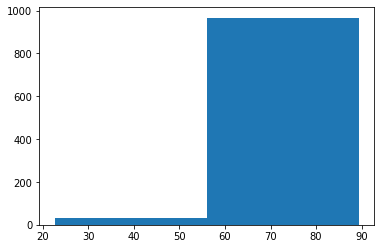

In [403]:
import matplotlib.pyplot as plt


print(len([x for x in train_targets if x < 80.0]))
print(len([x for x in train_targets if x > 80.0]))


plt.hist(train_targets,bins=2)
plt.show()


In [404]:
import pickle
import logging

from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB

logging.getLogger('hpbandster').setLevel(logging.DEBUG)

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
import torch.nn as nn

hbster = False


In [405]:
############### evaluate function

def evaluate_model(model, criterion, dataloader):
    
    test_losses = []
    msqrt = 0
    counter = 0
    test_loss_sum_list = []

    model.eval()
    for inputs,configs, labels in dataloader:
        batch_size_calc = len(labels)
        counter = counter +1
        h = model.init_hidden(batch_size_calc)
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs,configs, h)
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        
        test_loss_sum = criterion_val(output.squeeze(), labels.float())/(batch_size_calc)
        test_loss_sum_list.append(test_loss_sum.item())

        
        pred = (output.squeeze())
        
        
    print("Test loss: {:.3f}".format(np.mean(test_loss_sum_list)))

    return np.mean(test_loss_sum_list)

In [406]:
def val_model(model, criterion, dataloader):


    val_losses = []
    model.eval()
    test_loss_sum_list = []

    for inp,configs, lab in self.validation_loader:

        batch_size_calc = len(lab)

        val_h = model.init_hidden(batch_size = batch_size_calc)


        inp, lab = inp.to(device), lab.to(device)
        out, val_h = model(inp, configs,val_h)#
        
        test_loss_sum = criterion_val(out.squeeze(), lab.float())/(batch_size_calc)
        test_loss_sum_list = test_loss_sum_list.append(test_loss_sum)

        
        val_loss = abs(criterion(out.squeeze(), lab.float()))
        val_losses.append(val_loss.item())

        print("Epoch: {}/{}...".format(epoch, int(budget)),
              "Step: {}...".format(counter),
              "Loss: {:.6f}...".format(loss.item()),
              "Val Loss: {:.6f}".format(np.mean(test_loss_sum_list)))



In [407]:

def create_model_BOHB(hidden_dim, num_layers, relative_size = 0.75, dropout = 0.5):
    
    
    def weights_init(m):
        for name, param in m.named_parameters():
            torch.nn.init.uniform_(param) 
            
    
    outcome_dim = 1
    seq_length = 10
    config_size = 7
    input_size = 1

    model = LSTM_Net(input_size, outcome_dim, hidden_dim, seq_length, num_layers, config_size,
                     relative_size = relative_size, drop_prob = dropout)
    model.to(device)
    
    model.apply(weights_init)

    
    return model

In [408]:
class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.train_loader = prep_data(train_data, train_targets, batch_size = 32,first_n_epochs = 10)
        self.test_loader = prep_data(test_data, test_targets, batch_size = 32,first_n_epochs = 10)
        self.validation_loader = prep_data(val_data, val_targets, batch_size = 32, first_n_epochs=10)

    @staticmethod
    def get_model(config: CS.Configuration) -> nn.Module:
        """ Define a configurable convolution model.
            
        See description of get_conv_model above for more details on the model.
        """
        # START TODO ################ (1point)
        # raise NotImplementedError  
        
        hidden_dim = config['hidden_dim']
        num_layers = config['num_layers']
        relative_size = config['relative_size']
        dropout = config['dropout']
        
        model = create_model_BOHB(hidden_dim, num_layers, relative_size = relative_size, dropout = dropout)
        return model
    
        # END TODO ################
        
    @staticmethod
    def get_configspace() -> CS.Configuration:
        """ Define a conditional hyperparameter search-space.
    
        """

        cs = CS.ConfigurationSpace()
        
        
        num_layers_cs = CSH.UniformIntegerHyperparameter("num_layers",lower=1,upper=5)
        hidden_dim_cs = CSH.UniformIntegerHyperparameter("hidden_dim",lower=5,upper=500)
        
        lr = CSH.UniformFloatHyperparameter("lr",lower=1e-6,upper=1e-1,log=True)
        weight_decay = CSH.UniformFloatHyperparameter("weight_decay",lower=1e-6,upper=1e-1,log=True)
        relative_size = CSH.UniformFloatHyperparameter("relative_size",lower=0.1,upper=1.0)
        sgd_momentum = CSH.UniformFloatHyperparameter("sgd_momentum",lower=0.00,upper=0.99)
        dropout = CSH.UniformFloatHyperparameter("dropout",lower=0.1,upper=0.8)

        optimizer = CSH.CategoricalHyperparameter('optimizer', choices=['Adam', 'SGD'])
        t_max =  CSH.UniformIntegerHyperparameter("T_max",lower=10,upper=max_budget)
        
        cs.add_hyperparameters([num_layers_cs,dropout,t_max ,hidden_dim_cs, weight_decay, lr, relative_size, sgd_momentum, optimizer])
    
        condition3 = CS.EqualsCondition(sgd_momentum,optimizer,'SGD')
        cs.add_condition(condition3)
        
    
        
        return cs

    def compute(self, config: CS.Configuration, budget: float, working_directory: str,
                *args, **kwargs) -> dict:
        """Evaluate a function with the given config and budget and return a loss.
        
        Bohb tries to minimize the returned loss.
        
        In our case the function is the training and validation of a model,
        the budget is the number of epochs and the loss is the validation error.
        """
        model = self.get_model(config)
        
        criterion = torch.nn.MSELoss()
        if config['optimizer'] == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay = config["weight_decay"])
        
        else:
                optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['sgd_momentum'], weight_decay = config["weight_decay"])

                
        t_max = config['T_max']
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, t_max)

        
        clip = 5
        
        model.train()

        for epoch in range(int(budget)):
            
            for batches, configs , labels in self.train_loader:
                batch_size_calc = len(labels)
                hidden = model.init_hidden(batch_size=batch_size_calc)
                model.zero_grad()
                output, hidden = model(batches, configs, hidden)
                loss = criterion(output.squeeze(), labels.float())
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                
            scheduler.step()

            
        train_loss = evaluate_model(model, criterion,  self.train_loader)
        val_loss = evaluate_model(model, criterion, self.validation_loader)
        test_loss = evaluate_model(model, criterion, self.test_loader)

        
                
        return ({
                'loss': val_loss,  # remember: HpBandSter minimizes the loss!
                'info': {'test_accuracy': test_loss,
                         'train_accuracy': train_loss,
                         'valid_accuracy': val_loss,
                         'model': str(model)}
                })
        
        
   

In [409]:
working_dir = '/home/sven/LCBench/'
# minimum budget that BOHB uses
min_budget = 200
# largest budget BOHB will use
max_budget = 1000

In [410]:
if hbster:
    worker = PyTorchWorker(run_id='0')
    cs = worker.get_configspace()

    config = cs.sample_configuration().get_dictionary()
    print(config)

    res = worker.compute(config=config, budget=min_budget, working_directory=working_dir)
    print(res)

{'T_max': 287, 'dropout': 0.43885485900234245, 'hidden_dim': 116, 'lr': 0.004965710218824816, 'num_layers': 2, 'optimizer': 'Adam', 'relative_size': 0.7660771906581066, 'weight_decay': 0.00011755110999779851}
Test loss: 4.806
Test loss: 5.662
Test loss: 4.164
{'loss': 5.6617428213357925, 'info': {'test_accuracy': 4.1643142476677895, 'train_accuracy': 4.805712576955557, 'valid_accuracy': 5.6617428213357925, 'model': 'LSTM_Net(\n  (dropout): Dropout(p=0.43885485900234245, inplace=False)\n  (rnn1): RNN(1, 116, num_layers=2)\n  (linear1): Linear(in_features=7, out_features=88, bias=True)\n  (linear2): Linear(in_features=88, out_features=88, bias=True)\n  (linear3): Linear(in_features=204, out_features=204, bias=True)\n  (linear4): Linear(in_features=204, out_features=58, bias=True)\n  (linear5): Linear(in_features=58, out_features=1, bias=True)\n  (dropout2): Dropout(p=0.43885485900234245, inplace=False)\n  (linear_reduce1): Linear(in_features=1160, out_features=580, bias=True)\n  (linear_

In [411]:
import os

In [412]:
if hbster:    
    
    result_file = os.path.join(working_dir, 'bohb_result.pkl')
    nic_name = 'lo0'
    port = 0
    run_id = 'bohb_run_1'
    n_bohb_iterations = 25

In [ ]:
if hbster:
    
    try:
        # Start a nameserver
        #host = hpns.nic_name_to_host(nic_name)
        ns = hpns.NameServer(run_id=run_id, host='127.0.0.1', port=port,
                             working_directory=working_dir)
        ns_host, ns_port = ns.start()
        #run(ns_host)
        # Start local worker
        w = PyTorchWorker(run_id=run_id, host='127.0.0.1', nameserver=ns_host,
                          nameserver_port=ns_port, timeout=500)
        w.run(background=True)

        # Run an optimizer
        bohb = BOHB(configspace=worker.get_configspace(),
                    run_id=run_id,
                    host='127.0.0.1',
                    nameserver=ns_host,
                    nameserver_port=ns_port,
                    min_budget=min_budget, max_budget=max_budget)

        result = bohb.run(n_iterations=n_bohb_iterations)
        print("Write result to file {}".format(result_file))
        with open(result_file, 'wb') as f:
            pickle.dump(result, f)
    finally:
        bohb.shutdown(shutdown_workers=True)
        ns.shutdown()

18:57:49 wait_for_workers trying to get the condition
18:57:49 DISPATCHER: started the 'discover_worker' thread
18:57:49 WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x7f448ef42320; connected IPv4; for PYRO:Pyro.NameServer@127.0.0.1:44085>
18:57:49 DISPATCHER: started the 'job_runner' thread
18:57:49 WORKER: No dispatcher found. Waiting for one to initiate contact.
18:57:49 WORKER: start listening for jobs
18:57:49 DISPATCHER: Pyro daemon running on 127.0.0.1:43121
18:57:49 DISPATCHER: Starting worker discovery
18:57:49 DISPATCHER: Found 1 potential workers, 0 currently in the pool.
18:57:49 DISPATCHER: discovered new worker, hpbandster.run_bohb_run_1.worker.sven-Lenovo-IdeaPad-L340-17API.8384139935532400768
18:57:49 HBMASTER: number of workers changed to 1
18:57:49 Enough workers to start this run!
18:57:49 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
18:57:49 adjust_queue_size: lock accquired
18:57:49 HBMASTER: starting run at 1580925469.8871536
18:5

Test loss: 1345817536018180582374067142656.000
Test loss: 1281483020841830882511851356160.000
Test loss: 1346225697236844730114354708480.000


19:28:15 WORKER: done with job (0, 0, 0), trying to register it.
19:28:15 WORKER: registered result for job (0, 0, 0) with dispatcher
19:28:15 DISPATCHER: job (0, 0, 0) finished
19:28:15 DISPATCHER: register_result: lock acquired
19:28:16 DISPATCHER: job (0, 0, 0) on hpbandster.run_bohb_run_1.worker.sven-Lenovo-IdeaPad-L340-17API.8384139935532400768 finished
19:28:16 job_id: (0, 0, 0)
kwargs: {'config': {'T_max': 174, 'dropout': 0.4673956674368789, 'hidden_dim': 365, 'lr': 0.008121916032262325, 'num_layers': 1, 'optimizer': 'SGD', 'relative_size': 0.4391985504432502, 'weight_decay': 7.713318355328748e-06, 'sgd_momentum': 0.136064389218762}, 'budget': 333.3333333333333, 'working_directory': '.'}
result: {'loss': 1.281483020841831e+30, 'info': {'test_accuracy': 1.3462256972368447e+30, 'train_accuracy': 1.3458175360181806e+30, 'valid_accuracy': 1.281483020841831e+30, 'model': 'LSTM_Net(\n  (dropout): Dropout(p=0.4673956674368789, inplace=False)\n  (rnn1): RNN(1, 365)\n  (linear1): Linear(

Test loss: 76.030
Test loss: 68.757


19:34:03 WORKER: done with job (0, 0, 1), trying to register it.
19:34:03 DISPATCHER: job (0, 0, 1) finished
19:34:03 WORKER: registered result for job (0, 0, 1) with dispatcher
19:34:03 DISPATCHER: register_result: lock acquired
19:34:03 DISPATCHER: job (0, 0, 1) on hpbandster.run_bohb_run_1.worker.sven-Lenovo-IdeaPad-L340-17API.8384139935532400768 finished
19:34:03 job_id: (0, 0, 1)
kwargs: {'config': {'T_max': 717, 'dropout': 0.49081563972406295, 'hidden_dim': 38, 'lr': 0.021898813588612762, 'num_layers': 4, 'optimizer': 'Adam', 'relative_size': 0.4553952479483574, 'weight_decay': 0.00010637272577328577}, 'budget': 333.3333333333333, 'working_directory': '.'}
result: {'loss': 68.75661373138428, 'info': {'test_accuracy': 66.12546408176422, 'train_accuracy': 76.02973634004593, 'valid_accuracy': 68.75661373138428, 'model': 'LSTM_Net(\n  (dropout): Dropout(p=0.49081563972406295, inplace=False)\n  (rnn1): RNN(1, 38, num_layers=4)\n  (linear1): Linear(in_features=7, out_features=17, bias=

Test loss: 66.125


19:34:50 DISPATCHER: Starting worker discovery
19:34:50 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
19:34:50 DISPATCHER: Finished worker discovery
19:35:50 DISPATCHER: Starting worker discovery
19:35:50 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
19:35:50 DISPATCHER: Finished worker discovery
19:36:50 DISPATCHER: Starting worker discovery
19:36:50 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
19:36:50 DISPATCHER: Finished worker discovery
19:37:50 DISPATCHER: Starting worker discovery
19:37:50 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
19:37:50 DISPATCHER: Finished worker discovery
19:38:50 DISPATCHER: Starting worker discovery
19:38:50 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
19:38:50 DISPATCHER: Finished worker discovery
19:39:50 DISPATCHER: Starting worker discovery
19:39:50 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
19:39:50 DISPATCHER: Finished worker discover

20:23:51 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
20:23:51 DISPATCHER: Finished worker discovery
20:24:51 DISPATCHER: Starting worker discovery
20:24:51 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
20:24:51 DISPATCHER: Finished worker discovery
20:25:51 DISPATCHER: Starting worker discovery
20:25:51 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
20:25:51 DISPATCHER: Finished worker discovery
20:26:51 DISPATCHER: Starting worker discovery
20:26:51 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
20:26:51 DISPATCHER: Finished worker discovery
20:27:51 DISPATCHER: Starting worker discovery
20:27:51 DISPATCHER: Found 1 potential workers, 1 currently in the pool.
20:27:51 DISPATCHER: Finished worker discovery


Test loss: 8049043577466798926151439876096.000
Test loss: 8019157250043457391359007129600.000


20:28:38 WORKER: done with job (0, 0, 2), trying to register it.


Test loss: 8426634273362101045969431822336.000


20:28:39 WORKER: registered result for job (0, 0, 2) with dispatcher
20:28:39 DISPATCHER: job (0, 0, 2) finished
20:28:39 DISPATCHER: register_result: lock acquired
20:28:39 DISPATCHER: job (0, 0, 2) on hpbandster.run_bohb_run_1.worker.sven-Lenovo-IdeaPad-L340-17API.8384139935532400768 finished
20:28:39 job_id: (0, 0, 2)
kwargs: {'config': {'T_max': 92, 'dropout': 0.14482248402059622, 'hidden_dim': 409, 'lr': 1.0958586902536608e-06, 'num_layers': 4, 'optimizer': 'SGD', 'relative_size': 0.7940162045133444, 'weight_decay': 0.0011624974152256386, 'sgd_momentum': 0.6759900433576366}, 'budget': 333.3333333333333, 'working_directory': '.'}
result: {'loss': 8.019157250043457e+30, 'info': {'test_accuracy': 8.426634273362101e+30, 'train_accuracy': 8.049043577466799e+30, 'valid_accuracy': 8.019157250043457e+30, 'model': 'LSTM_Net(\n  (dropout): Dropout(p=0.14482248402059622, inplace=False)\n  (rnn1): RNN(1, 409, num_layers=4)\n  (linear1): Linear(in_features=7, out_features=324, bias=True)\n  (l

Test loss: 60.407
Test loss: 53.319


20:46:06 WORKER: done with job (0, 0, 1), trying to register it.
20:46:06 WORKER: registered result for job (0, 0, 1) with dispatcher
20:46:06 DISPATCHER: job (0, 0, 1) finished
20:46:06 DISPATCHER: register_result: lock acquired
20:46:06 DISPATCHER: job (0, 0, 1) on hpbandster.run_bohb_run_1.worker.sven-Lenovo-IdeaPad-L340-17API.8384139935532400768 finished
20:46:06 job_id: (0, 0, 1)
kwargs: {'config': {'T_max': 717, 'dropout': 0.49081563972406295, 'hidden_dim': 38, 'lr': 0.021898813588612762, 'num_layers': 4, 'optimizer': 'Adam', 'relative_size': 0.4553952479483574, 'weight_decay': 0.00010637272577328577}, 'budget': 1000.0, 'working_directory': '.'}
result: {'loss': 53.3189001083374, 'info': {'test_accuracy': 52.64789843559265, 'train_accuracy': 60.407166600227356, 'valid_accuracy': 53.3189001083374, 'model': 'LSTM_Net(\n  (dropout): Dropout(p=0.49081563972406295, inplace=False)\n  (rnn1): RNN(1, 38, num_layers=4)\n  (linear1): Linear(in_features=7, out_features=17, bias=True)\n  (li

Test loss: 52.648


20:46:06 start sampling a new configuration.
20:46:07 done sampling a new configuration.
20:46:07 HBMASTER: schedule new run for iteration 1
20:46:07 HBMASTER: trying submitting job (1, 0, 0) to dispatcher
20:46:07 HBMASTER: submitting job (1, 0, 0) to dispatcher
20:46:07 DISPATCHER: trying to submit job (1, 0, 0)
20:46:07 DISPATCHER: trying to notify the job_runner thread.
20:46:07 HBMASTER: job (1, 0, 0) submitted to dispatcher
20:46:07 DISPATCHER: Trying to submit another job.
20:46:07 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
20:46:07 DISPATCHER: starting job (1, 0, 0) on hpbandster.run_bohb_run_1.worker.sven-Lenovo-IdeaPad-L340-17API.8384139935532400768
20:46:07 DISPATCHER: job (1, 0, 0) dispatched on hpbandster.run_bohb_run_1.worker.sven-Lenovo-IdeaPad-L340-17API.8384139935532400768
20:46:07 WORKER: start processing job (1, 0, 0)
20:46:07 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
20:46:07 WORKER: args: ()
20:46:07 WORKER: kwargs: {'config

In [ ]:
#  load a saved result object if necessary
if hbster:  
    
    with open(result_file, 'rb') as f:
        result = pickle.load(f)

In [ ]:
if hbster:    
    
    all_runs_largest_budget = result.get_all_runs(only_largest_budget=True)
    val_accs= []
    for i in range(len(all_runs_largest_budget)):
      val_accs.append(all_runs_largest_budget[i]['info']['valid_accuracy'])
    val_accs = np.array(val_accs)
    arg = np.argmin(val_accs)
    print(all_runs_largest_budget[arg]['info']['model'])
    print(all_runs_largest_budget[arg]['info']['valid_accuracy'])
    print(all_runs_largest_budget[arg]['config'])



## A simple baseline

In [ ]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [ ]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
for data in train_data:
    data['Train/val_accuracy']=data['Train/val_accuracy'][0:10]

predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)

In [ ]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)